### 2024 freeway

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)

In [10]:
def get_path_working_data():
    path_working = pd.read_csv('道路施工路段資料sum.csv', low_memory=False)
    
    #datacleaning
    path_working = path_working.drop(index=0)
    path_working['incStepTime'] = pd.to_datetime(path_working['incStepTime'], format='%Y/%m/%d %H:%M')
    path_working['incStepEndTime'] = pd.to_datetime(path_working['incStepEndTime'], format='%Y/%m/%d %H:%M')
    path_working['incStepStartMileage'] = path_working['incStepStartMileage'].astype(int)
    path_working['incStepEndMileage'] = path_working['incStepEndMileage'].astype(int)
    
    def process_element(row):
        try:
            inside_side_road = 0 if row['incStepBlockagePattern'][0] != '1' else 1
            path = 0 if '1' not in row['incStepBlockagePattern'][1:9] else 1
            outside_side_road = 0 if row['incStepBlockagePattern'][9] != '1' else 1
            inside_slope = 0 if row['incStepBlockagePattern'][10] != '1' else 1
            outside_slope = 0 if row['incStepBlockagePattern'][11] != '1' else 1
            central_split = 0 if row['incStepBlockagePattern'][12] != '1' else 1
            weighting_path = 0 if row['incStepBlockagePattern'][13] != '1' else 1
            return pd.Series([inside_side_road, path, outside_side_road, inside_slope, outside_slope, central_split, weighting_path])
        except:
            return pd.Series([1, 1, 1, 1, 1, 1, 1])

    # Apply the function to create new columns
    new_columns = ['inside side road', 'path', 'outside side road', 'inside slope', 'outside slope', 'central split', 'weighting path']
    path_working[new_columns] = path_working.apply(process_element, axis=1)
    return path_working


In [11]:
path_working = get_path_working_data()
unuse_column = ['incStepIncidentId','incStepNum','incStepBlockagePattern']
path_working.drop(columns=unuse_column, inplace=True)
path_working.head()

,incStepTime,incStepEndTime,incStepFreewayId,incStepDirection,incStepStartMileage,incStepEndMileage,Category,inside side road,path,outside side road,inside slope,outside slope,central split,weighting path
1,2023-01-01 07:45:00,2023-01-01 16:06:00,10050,1,54300,54300,Train,1,1,1,1,1,1,1
2,2023-01-01 08:21:00,2023-01-01 08:25:00,10040,3,108,108,Train,1,1,1,1,1,1,1
3,2023-01-01 08:48:00,2023-01-01 16:41:00,10030,1,35900,35900,Train,1,1,1,1,1,1,1
4,2023-01-01 08:49:00,2023-01-01 16:41:00,10030,2,25650,25400,Train,1,1,1,1,1,1,1
5,2023-01-01 09:26:00,2023-01-01 16:52:00,10010,1,25100,25100,Train,1,1,1,1,1,1,1


In [28]:
traffic_issue = pd.read_csv('交通事故簡訊通報資料sum.csv',low_memory=False)

def clean_string(s):
    if isinstance(s, str):
        return s.replace('\n', '').replace('\r', '').replace('#VALUE!','OTHER').replace('#REF!','OTHER').replace('"','')
    return s

# Apply the function to each element in the DataFrame
traffic_issue = traffic_issue.applymap(clean_string)

car_columns = ['車輛1', '車輛2','車輛3', '車輛4', '車輛5', '車輛6', '車輛7', '車輛8', '車輛9', '車輛10', '車輛11', '車輛12']
category_dict  = {
    '小自客': '1',
    '大貨車': '2',
    '小貨車': '3',
    '大客車': '4',
    '小客車': '1',
    '小貨': '3',
    '大貨': '2',
    '聯結車': '5',
    '其他': '5',
    'OTHER': '5',
    '拖吊車': '5',
    None: None,  # 處理缺失值
    '槽車': '5',
    '垃圾車': '5',
    '貨櫃車': '5',
    '中型貨車': '2',
    '工程車': '5',
    '緩撞車': '5',
    '貨車': '2',
    '連結車': '5',
    '計程車': '5',
    '事故班緩撞車': '5',
    '施工車': '5',
    '施工緩撞車': '5',
    '油罐車': '5',
    '預拌水泥車': '5',
    '起重機': '5',
    '小自車': '1',
    '公警': '5',
    '拖板車': '5',
    '砂石車': '5'
}
for car in car_columns:
    traffic_issue[car] = traffic_issue[car].map(category_dict)
    
## 車道部分四個分局都一致化

#增加新column用車子去反紀錄crash數，因為分局1都是空值
# traffic_issue[(traffic_issue['肇事車輛']!=traffic_issue['crash car count']) & (traffic_issue['分局']!=1)]
traffic_issue['crash car count'] = traffic_issue[car_columns].apply(lambda row: row.replace('', pd.NA).count(), axis=1)

# 組合 '年', '月', '日', '時', '分' 列為 datetime
traffic_issue['datetime'] = pd.to_datetime(traffic_issue[['年', '月', '日', '時', '分']].rename(columns={'年': 'year', '月': 'month', '日': 'day', '時': 'hour', '分': 'minute'}))

route_to_code = {
    '國道1號': 10010,
    '國道2號': 10020,
    '國2甲':10020,
    '國道3號': 10030,
    '國3甲': 10031,
    '國道3甲': 10031,
    '國道4號': 10040,
    '國道5號': 10050,
    '國道6號': 10060,
    '國道8號': 10080,
    '國道10號': 10100,
    '港西聯外道路': 'OTHER',
    '南港連絡道': 'OTHER',
    None:None,
    'OTHER':'OTHER',
}
traffic_issue['國道名稱'] = traffic_issue['國道名稱'].map(route_to_code)

direction_to_number = {
    '南': '1',
    '北': '2',
    '東': '3',
    '西': '4',
    '南向': '1',
    '北向': '2',
    '東向': '3',
    '西向': '4',
    '南北':'12',
    '雙向':'1234',
}
traffic_issue['方向'] = traffic_issue['方向'].map(direction_to_number)

mes_to_number = {
    '北控通報': 1,
    '中控通報': 2,
    '高公局中': 2,
    '南控通報': 3,
    '高公局南': 3,
    '高公局北': 1,
    '坪控通報': 4,
    '北通報3': 1,
    '中控通2': 2,
}
#test data had no 分局 column
traffic_issue['分局'] = traffic_issue['簡訊內容'].str[0:4].map(mes_to_number)

missing_data_indices = traffic_issue[traffic_issue['事故類型'].isnull()].index
for idx in missing_data_indices:
    element = traffic_issue.loc[idx, '簡訊內容'][4]
    if element == '2':
        traffic_issue.loc[idx, '事故類型'] = 'A2'
    elif element == '3':
        traffic_issue.loc[idx, '事故類型'] = 'A3'
    elif element == '控':
        traffic_issue.loc[idx, '事故類型'] = 'A3'
        
traffic_issue[['死亡', '受傷']] = traffic_issue[['死亡', '受傷']].applymap(lambda x: 0 if pd.isnull(x) else x)

# Assuming 'df' is your existing DataFrame with 'dead' and 'injury' columns
# Add 'is_death' column where it's True if 'dead' is not 0, otherwise False
traffic_issue['is_death'] = traffic_issue['死亡'] != 0

# Add 'is_injury' column where it's True if 'injury' is not 0, otherwise False
traffic_issue['is_injury'] = traffic_issue['受傷'] != 0

# Initialize the new columns 'type1' to 'type5' with zeros
for i in range(1, 6):
    traffic_issue[f'car_type{i}_ratio'] = 0

# Count the occurrences of each number (1-5) in each row and update the 'type' columns
for index, row in traffic_issue.iterrows():
    for i in range(1, 6):
        if row['crash car count']:
            traffic_issue.at[index, f'car_type{i}_ratio'] = list(row['車輛1':'車輛12']).count(str(i))/row['crash car count']
        else:
            traffic_issue.at[index, f'car_type{i}_ratio']=0
# Now 'df' has new columns 'type1' to 'type5' with the counts of numbers 1 to 5 respectively


C:\Users\Dell\AppData\Local\Temp\ipykernel_12196\424947665.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  traffic_issue = traffic_issue.applymap(clean_string)
C:\Users\Dell\AppData\Local\Temp\ipykernel_12196\424947665.py:114: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  traffic_issue[['死亡', '受傷']] = traffic_issue[['死亡', '受傷']].applymap(lambda x: 0 if pd.isnull(x) else x)


### 處理進度
車輛完成:
'肇事車輛', '車輛1', '車輛2','車輛3', '車輛4', '車輛5', '車輛6', '車輛7', '車輛8', '車輛9', '車輛10', '車輛11', '車輛12'
分局部分沒問題

時間組合
'年', '月', '日', '時', '分'

車禍車道位置沒問題
'內路肩', '內車道', '中內車道','中車道', '中外車道', '外車道', '外路肩', '匝道'

無法運用:
'事件發生', '交控中心\n接獲通報','CCTV\n監看現場', 'CMS\n發布資訊', '交控中心\n通報工務段', '事故處理\n小組出發', '事故處理\n小組抵達','事故處理\n小組完成', '事件排除'

國道名稱,方向 處理完畢

當作沒問題
'翻覆事故\n註記','施工事故\n註記', '危險物品車輛\n註記', '車輛起火\n註記', '冒煙車事故\n註記', '主線中斷\n註記',

In [40]:
unuse_column = ['肇事車輛', '事件發生', '交控中心\n接獲通報','CCTV\n監看現場', 'CMS\n發布資訊', '交控中心\n通報工務段', '事故處理\n小組出發', '事故處理\n小組抵達','事故處理\n小組完成', '事件排除',
                  '年', '月', '日', '分','簡訊內容','車輛1', '車輛2', '車輛3',
       '車輛4', '車輛5', '車輛6', '車輛7', '車輛8', '車輛9', '車輛10', '車輛11', '車輛12']
traffic_issue.drop(columns=unuse_column, inplace=True)


In [41]:
traffic_issue.columns
# 事故類型 可以用簡訊內容前面字去補
# 受傷可以用 無受傷  無人受傷  無人員受傷 去抓0的  要想想如何抓有受傷的

Index(['時', '國道名稱', '方向', '里程', '處理分鐘', '事故類型', '死亡', '受傷', '內路肩', '內車道',
       '中內車道', '中車道', '中外車道', '外車道', '外路肩', '匝道', '翻覆事故\n註記', '施工事故\n註記',
       '危險物品車輛\n註記', '車輛起火\n註記', '冒煙車事故\n註記', '主線中斷\n註記', '分局', 'Category',
       'crash car count', 'datetime', 'is_death', 'is_injury',
       'car_type1_ratio', 'car_type2_ratio', 'car_type3_ratio',
       'car_type4_ratio', 'car_type5_ratio'],
      dtype='object')

In [42]:
traffic_issue.head()

,時,國道名稱,方向,里程,處理分鐘,事故類型,死亡,受傷,內路肩,內車道,中內車道,中車道,中外車道,外車道,外路肩,匝道,翻覆事故\n註記,施工事故\n註記,危險物品車輛\n註記,車輛起火\n註記,冒煙車事故\n註記,主線中斷\n註記,分局,Category,crash car count,datetime,is_death,is_injury,car_type1_ratio,car_type2_ratio,car_type3_ratio,car_type4_ratio,car_type5_ratio
0,19,10030,1,54.0,41,A2,0.0,2.0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Train,2,2023-02-09 19:21:00,False,True,1.0,0.0,0.0,0.0,0.0
1,3,10010,1,6.0,75,A3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,Train,1,2023-02-10 03:36:00,False,False,1.0,0.0,0.0,0.0,0.0
2,5,10030,1,76.0,20,A3,0.0,0.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Train,2,2023-02-10 05:33:00,False,False,0.5,0.5,0.0,0.0,0.0
3,7,10030,2,98.0,9,A3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,Train,2,2023-02-10 07:35:00,False,False,1.0,0.0,0.0,0.0,0.0
4,7,10010,2,23.0,16,A3,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,1,Train,2,2023-02-10 07:52:00,False,False,1.0,0.0,0.0,0.0,0.0


In [23]:
path_working.head()

,incStepTime,incStepEndTime,incStepFreewayId,incStepDirection,incStepStartMileage,incStepEndMileage,Category,inside side road,path,outside side road,inside slope,outside slope,central split,weighting path
1,2023-01-01 07:45:00,2023-01-01 16:06:00,10050,1,54300,54300,Train,1,1,1,1,1,1,1
2,2023-01-01 08:21:00,2023-01-01 08:25:00,10040,3,108,108,Train,1,1,1,1,1,1,1
3,2023-01-01 08:48:00,2023-01-01 16:41:00,10030,1,35900,35900,Train,1,1,1,1,1,1,1
4,2023-01-01 08:49:00,2023-01-01 16:41:00,10030,2,25650,25400,Train,1,1,1,1,1,1,1
5,2023-01-01 09:26:00,2023-01-01 16:52:00,10010,1,25100,25100,Train,1,1,1,1,1,1,1


In [24]:
# Initialize a new column with default value 'N'
traffic_issue['issue_status'] = 'N'

# Check if the conditions match and update the 'issue_status' column
for _, row in path_working.iterrows():
    mask = (traffic_issue['國道名稱'] == row['incStepFreewayId']) & \
           (traffic_issue['方向'] == row['incStepDirection']) & \
           (traffic_issue['里程'].between(row['incStepStartMileage'], row['incStepEndMileage'])) & \
           (traffic_issue['datetime'].between(row['incStepTime'], row['incStepEndTime']))
    traffic_issue.loc[mask, 'issue_status'] = 'Y'

# Now df1 will have the new column 'issue_status' with 'Y' or 'N'


In [43]:
traffic_issue = traffic_issue.fillna(0)
#Trial on ML first

In [27]:
traffic_issue.to_csv('traffic.csv', index=False)

### Add new data detail
This is because when join competition, receive more data after ML already complete.
This data is not open to public, so would not share in git.

In [39]:
new_info = pd.read_csv('additional_sum_clean.csv')

C:\Users\Dell\AppData\Local\Temp\ipykernel_17708\3293125837.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  new_info = pd.read_csv('additional_sum_clean.csv')


In [40]:
new_info['datetime'] = pd.to_datetime(new_info[['年', '月', '日', '時', '分']].rename(columns={'年': 'year', '月': 'month', '日': 'day', '時': 'hour', '分': 'minute'}))

route_to_code = {
    '國道1號': 10010,
    '國道2號': 10020,
    '國2甲':10020,
    '國道3號': 10030,
    '國3甲': 10031,
    '國道3甲': 10031,
    '國道4號': 10040,
    '國道5號': 10050,
    '國道6號': 10060,
    '國道8號': 10080,
    '國道10號': 10100,
    '港西聯外道路': 'OTHER',
    '南港連絡道': 'OTHER',
    None:None,
    'OTHER':'OTHER',
}
new_info['R0ad_name'] = new_info['路線'].map(route_to_code)

# remove all '0' row
new_info = new_info[new_info['當事者屬(性)別']!='0']

# unuse_column = ['年', '月', '日', '分','秒','公里','公尺',' 縣市','市區鄉鎮','路線']
unuse_column = ['年', '月', '日', '分','秒','路線']
new_info.drop(columns=unuse_column, inplace=True)




In [ ]:
# source['datetime'] = source['datetime'].dt.floor('H')
# new_info['datetime'] = new_info['datetime'].dt.floor('H')

source['date'] = source['datetime'].dt.date
new_info['date'] = new_info['datetime'].dt.date


In [30]:
new_info['事故類型及型態2'].unique()

array(['同向擦撞', '追撞', '其他', '撞護欄(樁)', '倒車撞', '對向擦撞', '撞非固定設施', '撞工程施工',
       '撞動物', ' ', '側撞', '衝出路外', '撞交通島', '撞號誌、標誌桿', '衝進路中', '路口交岔撞',
       '撞建築物', '路上翻車、摔倒', '穿越道路中', '撞橋樑(橋墩)', '撞電桿', '對撞', '撞路樹',
       '從停車後(或中)穿出', '在路上作業中', '撞路樹、電桿', '撞橋樑、建築物', '同向通行中'], dtype=object)

In [43]:
new_info.to_csv('test.csv', index=False, encoding='utf-8-sig')


In [20]:
column = ['時', '事故類別', '路線', '里程', '分局', '工務段', '向', '車道線(側)名稱', ' 24小時內死亡人數',
       '2-30日內死亡人數', '受傷', '天候', '道路照明設備(11207新增)', '道路類別', '速限', ' 道路型態',
       ' 事故位置', '路面狀況-路面鋪裝', '路面狀況-路面狀態', '路面狀況-路面缺陷', '道路障礙-障礙物', '道路障礙-視距',
       '號誌-號誌種類', '號誌-號誌動作', '車道劃分設施-分向設施', '車道劃分設施-分道設施-快車道或一般車道間',
       '車道劃分設施-分道設施-快慢車道間', '車道劃分設施-分道設施-路面邊線', '事故類型及型態代碼', '事故類型及型態2',]
len(new_info[column].drop_duplicates())

45927

In [22]:
column = ['時', '事故類別', '路線', '里程', '分局', '工務段', '向', '車道線(側)名稱', ' 24小時內死亡人數',
       '2-30日內死亡人數', '受傷', '天候', '道路照明設備(11207新增)', '道路類別', '速限', ' 道路型態',
       ' 事故位置', '路面狀況-路面鋪裝', '路面狀況-路面狀態', '路面狀況-路面缺陷', '道路障礙-障礙物', '道路障礙-視距',
       '號誌-號誌種類', '號誌-號誌動作', '車道劃分設施-分向設施', '車道劃分設施-分道設施-快車道或一般車道間',
       '車道劃分設施-分道設施-快慢車道間', '車道劃分設施-分道設施-路面邊線', '事故類型及型態代碼', '事故類型及型態2','當事者區分(大類別)', '當事者區分(類別)','初步分析研判子類別-主要', ]
len(new_info[column].drop_duplicates())

51253

## Machine Learning Part
Many model had been tried, the last one decided to use.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
data = pd.read_csv('/kaggle/input/train2/Training.csv',low_memory=False)
data.fillna(0, inplace=True)

In [ ]:
#one hot encode
df_encoded = pd.get_dummies(data, columns=['Hour','R0ad_name', 'Direction', 'Type','branch',]) #one_hot_encode
column  = [x for x in list(df_encoded.columns) if x not in [' Category','datetime']]
df_encoded.replace(' ', 0, inplace=True)
df_encoded[column] = df_encoded[column].astype('float32')



In [ ]:
#drop column
unuse_column = ['Location', ]
df_encoded.drop(columns=unuse_column, inplace=True)

In [ ]:
#Prepare training data
# Assuming 'df' is your dataframe
# Separate data based on 'Type' column
train_df = df_encoded[df_encoded[" Category"] == "Train"]
test_df = df_encoded[df_encoded[" Category"] == "Test"]

# Split train and test data into features (X) and target (y)
X_train = train_df.drop(columns=["Time_Spend",' Category','datetime'])
y_train = train_df["Time_Spend"]

X_test = test_df.drop(columns=["Time_Spend",' Category','datetime'])
y_test = test_df["Time_Spend"]

# Assuming 'X_train' and 'X_test' are pandas DataFrames
# Convert them to numpy arrays and reshape for the LSTM input
X_train = np.array(X_train).reshape((X_train.shape[0], 1,X_train.shape[1] ))
X_test = np.array(X_test).reshape((X_test.shape[0], 1, X_test.shape[1]))


# Convert input data to float
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')


In [ ]:
#get shape
X_test.shape

In [ ]:
def get_plot(y_test, predictions):
    # Assuming 'predictions' and 'y_test' are available from your previous steps
    mae = mean_absolute_error(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)

    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    
    
    # Assuming 'y_test' and 'predictions' are numpy arrays or lists of the same length
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions)
    plt.title('Correlation between Actual and Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')

    # Plotting a line of best fit
    z = np.polyfit(y_test, predictions, 1)
    # p = np.poly1d(z)
    # plt.plot(y_test, p(y_test), color='magenta')

    plt.grid(True)
    plt.show()

In [ ]:
## not a good model
# MAE: 20.4915828704834
# MSE: 704.8704223632812
# RMSE: 26.549396514892578
model = Sequential()
model.add(LSTM(50, input_shape=(1, 102)))  # Adjust the input_shape to match the reshaped input data
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=16, validation_data=(X_test, y_test))

# Make predictions
predictions = model.predict(X_test)

get_plot(y_test, predictions)

In [ ]:
# MAE: 18.186214447021484
# MSE: 552.3303833007812
# RMSE: 23.501710891723633
from keras.layers import Bidirectional

model = Sequential()
model.compile(optimizer='adam', loss='mean_squared_error')
model.add(Bidirectional(LSTM(50), input_shape=(1, 102)))
model.add(Dense(1))

model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
get_plot(y_test, predictions)

In [ ]:
# MAE: 17.363239288330078
# MSE: 627.4100952148438
# RMSE: 25.048154830932617
model = Sequential()
model.compile(optimizer='adam', loss='mean_squared_error')
model.add(LSTM(50, return_sequences=True, input_shape=(1, 102)))
model.add(LSTM(50))
model.add(Dense(1))

model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
get_plot(y_test, predictions)

In [ ]:
# MAE: 13.058083534240723
# MSE: 305.9016418457031
# RMSE: 17.49004364013672
from keras.layers import Dropout

model = Sequential()
model.compile(optimizer='adam', loss='mean_squared_error')
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, input_shape=(1, 102)))
model.add(Dense(1))

model.fit(X_train, y_train, epochs=20, batch_size=16, validation_data=(X_test, y_test))

predictions = model.predict(X_test)
get_plot(y_test, predictions)

In [ ]:
# MAE: 11.71208667755127
# MSE: 270.7373962402344
# RMSE: 16.454099655151367
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

predictions = model.predict(X_test)
get_plot(y_test, predictions)

In [ ]:
# MAE: 9.619044303894043
# MSE: 236.21945190429688
# RMSE: 15.36943244934082
from keras.callbacks import EarlyStopping

# Create a Sequential model
model = Sequential()

# Add an LSTM layer with 50 units and dropout
model.add(LSTM(50, dropout=0.2, recurrent_dropout=0.2, input_shape=(1, 72)))

# Add more layers (you can customize the number of units and activation functions)
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

# Output layer (1 unit for regression)
model.add(Dense(1))

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=30, batch_size=8, validation_data=(X_test, y_test), callbacks=[early_stopping])

predictions = model.predict(X_test)
get_plot(y_test, predictions)

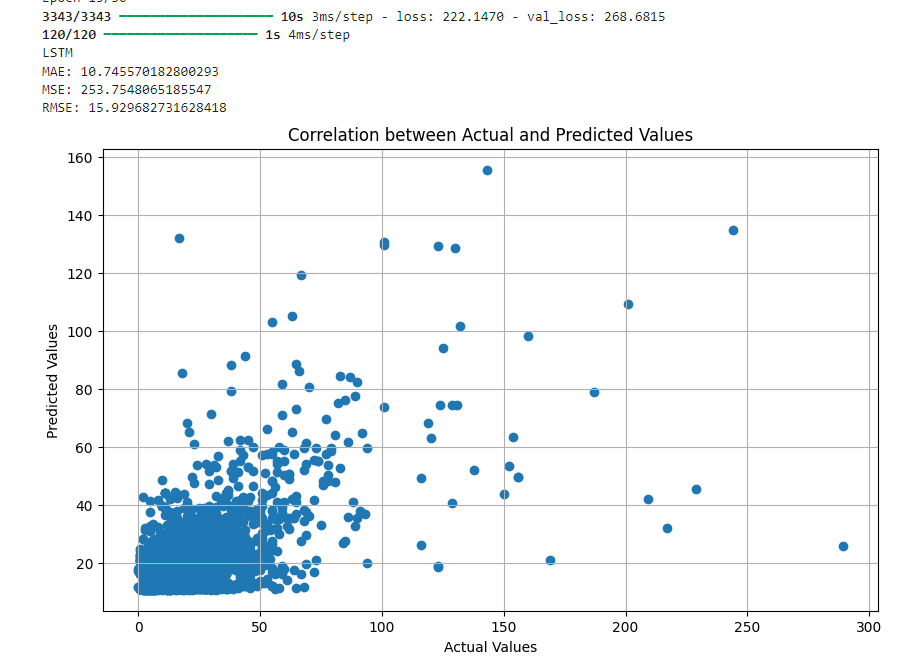